# Building a backprop engine

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

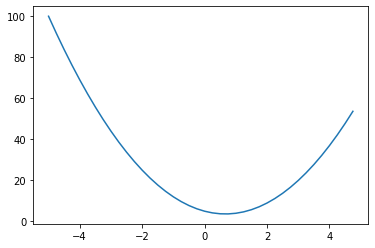

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# The definition of derivative

h = 0.0000000001
x = 3.0

(f(x + h) - f(x)) / h

14.000001158365194

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

d

4.0

In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

# The reason that the slope is one is because:
# ((a*b + c+h) - (a*b + c)) / h
# => h / h = 1

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [116]:
class Value:
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self.prev = set(children)
        self.op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), op="+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [117]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

print(a, b, c)

Value(data=2.0) Value(data=-3.0) Value(data=10.0)


In [10]:
z = a + b
z

Value(data=-1.0)

In [11]:
z.prev

{Value(data=-3.0), Value(data=2.0)}

In [12]:
z.op

'+'

In [13]:
y = a*b + c
y

Value(data=4.0)

In [14]:
y.prev

{Value(data=-6.0), Value(data=10.0)}

In [15]:
y.op

'+'

In [16]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [17]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

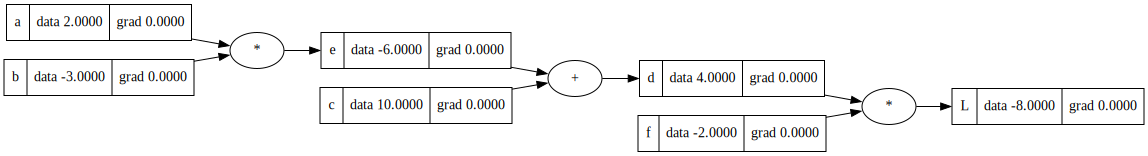

In [18]:
draw_dot(L)

In [19]:
# Use equations to solve gradients manually

# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# L = d * f; L.label = 'L'

In [20]:
L.grad = 1.0

In [21]:
f.grad = 4.0
d.grad = -2.0

In [22]:
# dL/de = dd/de * dL/dd
e.grad = -2.0
c.grad = -2.0

In [23]:
# dL/db = de/db * dd/de * dL/dd
# a * -2
b.grad = -4.0
a.grad = 6.0

In [24]:
# # Let's change values by their gradients (simulate gradient descent)
# lr = 0.01
#
# a.data += lr * a.grad
# b.data += lr * b.grad
# c.data += lr * c.grad
# f.data += lr * f.grad
#
# e = a * b
# d = e + c
# L = d * f
#
# print(L.data)

### Neurons Example

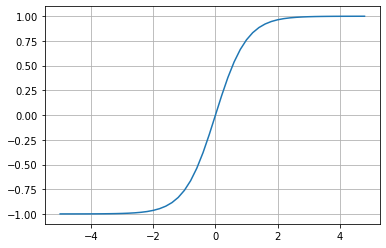

In [25]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [118]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'output'

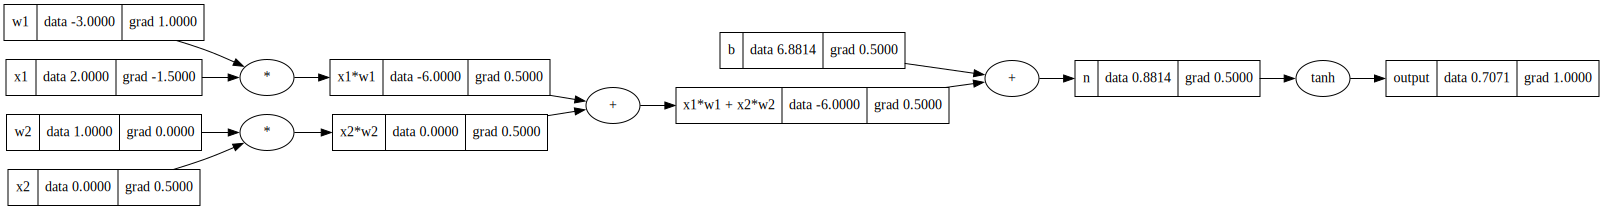

In [121]:
draw_dot(o)

In [28]:
o.grad = 1.0

In [29]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2

In [30]:
n.grad = 1 - o.data**2

In [31]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [32]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [33]:
# do/dw1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dw1
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

#### Call our backward() funtion

In [58]:
o.grad = 1.0

In [59]:
o._backward()

In [60]:
n._backward()

In [61]:
x1w1x2w2._backward()

In [62]:
x1w1._backward()

In [63]:
x2w2._backward()

#### Use backward with topological sort

In [128]:
o.backward()

# Building our own Neural Network

In [126]:
class Neuron:
    def __init__(self, nin):
        # init weights and biases between -1 and 1
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b => pass it through a non-linearity
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [136]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5497148562626694)

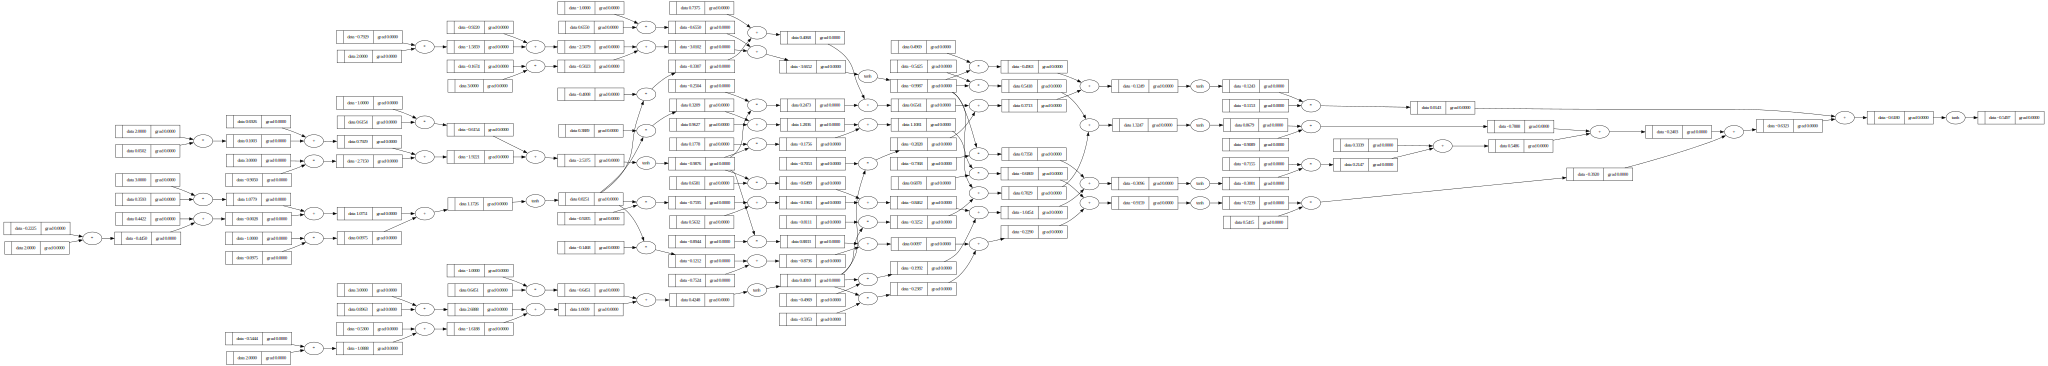

In [137]:
draw_dot(n(x))

In [138]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1.0]

In [139]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5497148562626694),
 Value(data=-0.9519663979736416),
 Value(data=-0.8408952999405592),
 Value(data=-0.8599472369665236)]

In [140]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 5.888641392525264
1 1.783498328332651
2 0.6977586386760242
3 0.3488209894310842
4 0.2128356508602961
5 0.15076493423906884
6 0.11542694191602984
7 0.09275455366735373
8 0.07710591164761153
9 0.06572085850246719
10 0.057101781430690765
11 0.050370967599796056
12 0.044982263203802816
13 0.040579165759172094
14 0.03691968460552182
15 0.03383412116445922
16 0.031200150462027423
17 0.028927492128951883
18 0.026948141106608037
19 0.02520994846894452


In [141]:
ypred

[Value(data=0.9302798212119943),
 Value(data=-0.9425113848799694),
 Value(data=-0.9024086925285992),
 Value(data=0.9132818301835391)]